# Notes

In [30]:
path_to_CNN = '/Users/DrV/PyProj/MRI_personality/sub-0001/nibabel_CNN'
path_to_excel = '/Users/DrV/code/lukevano/tables_2/'

# Imports

In [501]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import math

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Log Regression

## Description of loaded data

Three datasets are all merged in the following way:

Top 208 observations are ds002785, from 209 to 434 are ds002790, and from 435 to 1362 are ds003097

Columns have been concatenated so that the first columns are the participant details, then the targets, followed by the lt then rt cortical parcellations and lastly the volume segmentation of the subcortical structures.

Columns religious and raven have been deleted as not recorded in all datasets.

In [3]:
# Load the dataset
df = pd.read_excel('/Users/DrV/code/lukevano/tables_2/master_combined.xlsx')
df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol
0,sub-0001,26.25,F,24.0,right,applied,35,44,37,39,...,9.173525e+05,8.994205e+05,896844,1327933,0.861916,1.104817,12,15,27,1.201948e+06
1,sub-0002,21.00,F,23.0,right,academic,27,53,40,48,...,1.146516e+06,1.126214e+06,1124177,1601336,0.764482,0.946018,12,3,15,1.692713e+06
2,sub-0003,23.00,M,22.0,right,academic,35,40,43,37,...,1.041503e+06,1.029726e+06,1028008,1486426,0.904479,1.121519,7,8,15,1.325368e+06
3,sub-0004,23.50,F,22.0,right,applied,29,47,41,48,...,9.868068e+05,9.746908e+05,973108,1399947,0.847637,1.046196,14,9,23,1.338131e+06
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26,35,40,38,...,1.096504e+06,1.085620e+06,1084371,1552057,0.784204,0.981137,17,12,29,1.581897e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,sub-1358,22.25,male,21.0,right,medium,40,39,47,38,...,1.114540e+06,1.103578e+06,1101665,1607448,0.733615,0.921517,19,23,42,1.744349e+06
1358,sub-1359,25.25,male,30.0,right,medium,28,41,48,34,...,1.162712e+06,1.153654e+06,1150737,1660909,0.752255,0.933091,20,34,54,1.780007e+06
1359,sub-1360,20.75,male,22.0,right,high,27,44,46,41,...,1.130508e+06,1.101670e+06,1098852,1627185,0.697260,0.881901,20,33,53,1.845088e+06
1360,sub-1361,24.25,female,35.0,right,medium,35,32,44,45,...,9.487515e+05,9.420765e+05,939899,1351729,0.808297,1.003723,31,34,65,1.346715e+06


In [4]:
# Keep only the volume and thickness features and view correlations
vol_thick_features = df.iloc[:,11:]
corr = vol_thick_features.corr()
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df

,feature_1,feature_2,correlation
5113,eTIV,eTIV.1,1.0
5179,eTIV,EstimatedTotalIntraCranialVol,1.0
5020,BrainSegVolNotVent,BrainSegVolNotVent.2,1.0
4972,BrainSegVolNotVent,BrainSegVolNotVent.1,1.0
10115,BrainSegVolNotVent.1,BrainSegVolNotVent,1.0
...,...,...,...
19432,SurfaceHoles,Right-non-WM-hypointensities,NaN
19568,EstimatedTotalIntraCranialVol,Left-WM-hypointensities,NaN
19569,EstimatedTotalIntraCranialVol,Right-WM-hypointensities,NaN
19571,EstimatedTotalIntraCranialVol,Left-non-WM-hypointensities,NaN


In [5]:
# View the columns that are identical
corr_df[corr_df.correlation>0.999]

,feature_1,feature_2,correlation
5113,eTIV,eTIV.1,1.000000
5179,eTIV,EstimatedTotalIntraCranialVol,1.000000
5020,BrainSegVolNotVent,BrainSegVolNotVent.2,1.000000
4972,BrainSegVolNotVent,BrainSegVolNotVent.1,1.000000
10115,BrainSegVolNotVent.1,BrainSegVolNotVent,1.000000
16872,BrainSegVolNotVent.2,BrainSegVolNotVent.1,1.000000
16835,BrainSegVolNotVent.2,BrainSegVolNotVent,1.000000
19533,EstimatedTotalIntraCranialVol,eTIV.1,1.000000
19496,EstimatedTotalIntraCranialVol,eTIV,1.000000
10359,eTIV.1,EstimatedTotalIntraCranialVol,1.000000


In [6]:
# Make a list of the columns to remove and consider removing
# Remove idenical columns and hypointensity columns with virtually no values
to_remove = ['eTIV.1', 'EstimatedTotalIntraCranialVol', 'BrainSegVolNotVent.2',
    'BrainSegVolNotVent.1', 'BrainSegVolNotVentSurf', 'SupraTentorialVolNotVentVox',
    'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol', 'BrainSegVolNotVent.2', 
    'BrainSegVol', 'SupraTentorialVol', 'SupraTentorialVolNotVent',
    'BrainSegVol-to-eTIV', 'MaskVol', 'rhCortexVol', 'lhCortexVol', 'Left-WM-hypointensities',
    'Right-WM-hypointensities', 'non-WM-hypointensities', 'Left-non-WM-hypointensities',
    'Right-non-WM-hypointensities']
consider_removal = ['5th-Ventricle', 'SurfaceHoles', 'lhSurfaceHoles', 'rhSurfaceHoles']

In [7]:
vol_thick_features_less = vol_thick_features.drop(columns=to_remove)
corr_less = vol_thick_features_less.corr()
corr_less_df = corr_less.unstack().reset_index() # Unstack correlation matrix 
corr_less_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_less_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_less_df = corr_less_df[corr_less_df['feature_1'] != corr_less_df['feature_2']] # Remove self correlation
corr_less_df[corr_less_df.correlation>0.9]

,feature_1,feature_2,correlation
13912,TotalGrayVol,CortexVol,0.983605
13555,CortexVol,TotalGrayVol,0.983605
14397,SurfaceHoles,lhSurfaceHoles,0.958672
14159,lhSurfaceHoles,SurfaceHoles,0.958672
11235,Right-Cerebellum-Cortex,Left-Cerebellum-Cortex,0.956348
9093,Left-Cerebellum-Cortex,Right-Cerebellum-Cortex,0.956348
14398,SurfaceHoles,rhSurfaceHoles,0.951838
14279,rhSurfaceHoles,SurfaceHoles,0.951838
13835,TotalGrayVol,BrainSegVolNotVent,0.950506
4315,BrainSegVolNotVent,TotalGrayVol,0.950506


In [8]:
df_drop = df.drop(columns=to_remove)

In [9]:
df_drop.corr()['NEO_N'].sort_values(ascending=False)

NEO_N                            1.000000
NEO_O                            0.136066
rh_inferiortemporal_thickness    0.100484
rh_middletemporal_thickness      0.088380
lh_bankssts_thickness            0.085682
                                   ...   
Left-Accumbens-area             -0.103202
Right-Accumbens-area            -0.115273
Brain-Stem                      -0.127931
NEO_E                           -0.323274
NEO_C                           -0.358177
Name: NEO_N, Length: 127, dtype: float64

In [10]:
df_drop.corr()['NEO_E'].sort_values(ascending=False)

NEO_E                                1.000000
NEO_C                                0.199957
Optic-Chiasm                         0.175868
Left-Accumbens-area                  0.171150
NEO_O                                0.159415
                                       ...   
lh_superiorfrontal_thickness        -0.139352
rh_superiorfrontal_thickness        -0.139430
lh_rostralmiddlefrontal_thickness   -0.148245
lh_caudalmiddlefrontal_thickness    -0.155507
NEO_N                               -0.323274
Name: NEO_E, Length: 127, dtype: float64

In [11]:
df_drop.corr()['NEO_O'].sort_values(ascending=False)

NEO_O                            1.000000
NEO_E                            0.159415
NEO_N                            0.136066
Left-Putamen                     0.129670
Right-Putamen                    0.105202
                                   ...   
rh_middletemporal_thickness     -0.077697
rh_inferiorparietal_thickness   -0.078834
BMI                             -0.091675
lh_middletemporal_thickness     -0.092831
NEO_C                           -0.124567
Name: NEO_O, Length: 127, dtype: float64

In [12]:
df_drop.corr()['NEO_A'].sort_values(ascending=False)

NEO_A                   1.000000
MaskVol-to-eTIV         0.274711
NEO_C                   0.266463
Left-Accumbens-area     0.231139
Optic-Chiasm            0.220145
                          ...   
Left-VentralDC         -0.279316
Right-Pallidum         -0.283596
Right-Amygdala         -0.293897
Left-Thalamus-Proper   -0.306821
eTIV                   -0.329859
Name: NEO_A, Length: 127, dtype: float64

In [13]:
df_drop.corr()['NEO_C'].sort_values(ascending=False)

NEO_C                   1.000000
Left-Accumbens-area     0.328654
Optic-Chiasm            0.296591
MaskVol-to-eTIV         0.291598
NEO_A                   0.266463
                          ...   
rhSurfaceHoles         -0.239638
Left-Thalamus-Proper   -0.248308
SurfaceHoles           -0.249677
eTIV                   -0.259911
NEO_N                  -0.358177
Name: NEO_C, Length: 127, dtype: float64

## Preprocessing master_dup_removed v1

In [147]:
# Load the dataset
df_neo_nan = pd.read_excel('/Users/DrV/code/lukevano/tables_2/master_dup_removed v1.xlsx')
df_neo_nan

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,sub-1358,22.25,male,21.0,right,medium,40.0,39.0,47.0,38.0,...,898.8,887.2,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0
1358,sub-1359,25.25,male,30.0,right,medium,28.0,41.0,48.0,34.0,...,848.9,853.7,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0
1359,sub-1360,20.75,male,22.0,right,high,27.0,44.0,46.0,41.0,...,585.8,1128.7,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0
1360,sub-1361,24.25,female,35.0,right,medium,35.0,32.0,44.0,45.0,...,825.9,1005.8,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0


In [148]:
# Check for null values in main feat/targets
df_neo_nan.isnull().sum().sort_values(ascending=False).head(8)

BMI                     9
handedness              9
age                     9
sex                     8
NEO_C                   1
education_category      1
Brain-Stem              0
Left-Thalamus-Proper    0
dtype: int64

In [252]:
# Remove nan from NEO_C
df = df_neo_nan[df_neo_nan.NEO_C.notnull()].reset_index(drop=True) # reset or have empty indexes
df

,participant_id,age,sex,BMI,handedness,education_category,NEO_N,NEO_E,NEO_O,NEO_A,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,sub-0001,26.25,F,24.0,right,applied,35.0,44.0,37.0,39.0,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,sub-0002,21.00,F,23.0,right,academic,27.0,53.0,40.0,48.0,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,sub-0003,23.00,M,22.0,right,academic,35.0,40.0,43.0,37.0,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,sub-0004,23.50,F,22.0,right,applied,29.0,47.0,41.0,48.0,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,sub-0005,21.75,M,19.0,ambidextrous,applied,26.0,35.0,40.0,38.0,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,sub-1358,22.25,male,21.0,right,medium,40.0,39.0,47.0,38.0,...,898.8,887.2,517851.745617,517310.502374,66447.0,711842.745617,0.921517,19.0,23.0,42.0
1357,sub-1359,25.25,male,30.0,right,medium,28.0,41.0,48.0,34.0,...,848.9,853.7,519398.357112,565436.699430,65260.0,718521.357112,0.933091,20.0,34.0,54.0
1358,sub-1360,20.75,male,22.0,right,high,27.0,44.0,46.0,41.0,...,585.8,1128.7,567440.125601,469283.579026,61988.0,756582.125601,0.881901,20.0,33.0,53.0
1359,sub-1361,24.25,female,35.0,right,medium,35.0,32.0,44.0,45.0,...,825.9,1005.8,441752.267831,442438.198680,55159.0,595460.267831,1.003723,31.0,34.0,65.0


In [253]:
# Discretizing target: 0 = lower, 1 = higher
y_disc = df.iloc[:,6:11]
y = []
for i in range(5):
    y.append(pd.cut(x= y_disc.iloc[:,i], 
                    bins= [y_disc.iloc[:,i].min()-1, y_disc.iloc[:,i].mean(), y_disc.iloc[:,i].max()+1], 
                    labels= [0, 1]))
y = pd.DataFrame(y[0:5]).T
y.head()

,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,1,1,0,0,1
1,0,1,0,1,0
2,1,0,1,0,0
3,0,1,0,1,1
4,0,0,0,0,1


In [254]:
# Feature creation
X = df.iloc[:,11:]
X.head()

,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,lh_lateraloccipital_thickness,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,2.439,2.985,2.422,1.860,3.808,2.592,2.348,2.531,2.497,2.070,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,2.820,2.684,2.642,2.008,3.573,2.838,2.564,2.706,2.510,2.389,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,2.365,2.832,2.538,1.864,3.479,2.658,2.399,2.804,2.193,2.123,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,2.475,2.861,2.488,2.082,2.997,2.755,2.538,2.647,2.369,2.350,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,2.691,2.566,2.742,2.067,3.222,2.795,2.774,2.616,2.421,2.284,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0


In [255]:
# Check that no null in features and targets
print(X.isnull().sum().sum())
print(y.isnull().sum())

0
NEO_N    0
NEO_E    0
NEO_O    0
NEO_A    0
NEO_C    0
dtype: int64


## Building models and feature selection

Use statsmodels over sklearn as you can determine more about the features. When doing logisitic regression you are sacrificing quality for explainability: you know what is happening behind the model.

The two approaches for building models are either make a model with each feature individually and then start adding the features together or put all the features together and start to remove those that are too highly correlated.

In [285]:
# Add a constant as a feature- needed unless you want to go through origin on Logit
X_int = sm.add_constant(X)
X_int.head()

/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,1.0,2.439,2.985,2.422,1.860,3.808,2.592,2.348,2.531,2.497,...,474.1,954.7,431722.308490,412508.155809,52096.0,579143.308490,1.104817,12.0,15.0,27.0
1,1.0,2.820,2.684,2.642,2.008,3.573,2.838,2.564,2.706,2.510,...,534.4,1007.6,551229.524399,511140.955357,61775.0,729961.524399,0.946018,12.0,3.0,15.0
2,1.0,2.365,2.832,2.538,1.864,3.479,2.658,2.399,2.804,2.193,...,624.5,875.2,484203.743223,488806.827011,55089.0,666343.743223,1.121519,7.0,8.0,15.0
3,1.0,2.475,2.861,2.488,2.082,2.997,2.755,2.538,2.647,2.369,...,488.8,952.1,490562.774910,424675.040008,57767.0,666421.774910,1.046196,14.0,9.0,23.0
4,1.0,2.691,2.566,2.742,2.067,3.222,2.795,2.774,2.616,2.421,...,683.6,941.4,549885.250985,473013.916100,60987.0,723713.250985,0.981137,17.0,12.0,29.0


Build the models and work out what features to keep for each. If you standardise then you lose some information but it allows you to compare coeffiecients: if the feature is on a larger scale smaller coefficients make have a larger impact on the model. The null hypothesis is that the coef is 0 so if p>0.05 then can't prove not 0.

In [309]:
# Here is the output for a non-standardised model
# Will take longer to converge if not scaled= 41 iterations. Get the same accuracy:
# It will always converge on the global minima as Logit is a convex problem
results_NEO_N = sm.Logit(y['NEO_N'], X_int).fit(maxiter=100)
results_NEO_N.summary()

Optimization terminated successfully.
         Current function value: 0.638814
         Iterations 41


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                 1361
Model:                          Logit   Df Residuals:                     1240
Method:                           MLE   Df Model:                          120
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                 0.07456
Time:                        20:57:18   Log-Likelihood:                -869.43
converged:                       True   LL-Null:                       -939.47
Covariance Type:            nonrobust   LLR p-value:                    0.1014
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -8.2171      4.217     -1.949      0.051     -16.482       0.048
lh_bankssts_thickness                     0.6105      0.520      1.175      0.240      -0.408       1.629
lh_caudalanteriorcingulate_thickness      0.1630      0.345      0.473      0.636      -0.513       0.839
lh_caudalmiddlefrontal_thickness          0.3528      0.827      0.427      0.670      -1.268       1.973
lh_cuneus_thickness                      -0.0206      0.637     -0.032      0.974      -1.268       1.227
lh_entorhinal_thickness                  -0.2577      0.271     -0.950      0.342      -0.790       0.274
lh_fusiform_thickness                     0.3293      0.937      0.352      0.725      -1.507       2.165
lh_inferiorparietal_thickness             0.3837      1.195      0.321      0.748      -1.959       2.726
lh_inferiortemporal_thickness            -0.3039      0.886     -0.343      0.732      -2.041       1.433
lh_isthmuscingulate_thickness            -0.3246      0.472     -0.688      0.491      -1.249       0.600
lh_lateraloccipital_thickness             0.4710      1.138      0.414      0.679      -1.759       2.701
lh_lateralorbitofrontal_thickness         1.0654      0.757      1.407      0.160      -0.419       2.550
lh_lingual_thickness                      0.3732      0.792      0.471      0.638      -1.180       1.926
lh_medialorbitofrontal_thickness         -0.0183      0.583     -0.031      0.975      -1.160       1.124
lh_middletemporal_thickness               0.1780      0.834      0.214      0.831      -1.456       1.812
lh_parahippocampal_thickness             -0.4049      0.312     -1.299      0.194      -1.016       0.206
lh_paracentral_thickness                  0.6420      0.670      0.959      0.338      -0.670       1.954
lh_parsopercularis_thickness             -0.0724      0.695     -0.104      0.917      -1.435       1.290
lh_parsorbitalis_thickness               -0.5377      0.453     -1.188      0.235      -1.425       0.350
lh_parstriangularis_thickness             0.4784      0.654      0.732      0.464      -0.803       1.760
lh_pericalcarine_thickness                0.3019      0.683      0.442      0.659      -1.037       1.641
lh_postcentral_thickness                  1.3848      1.101      1.257      0.209      -0.774       3.544
lh_posteriorcingulate_thickness           0.0516      0.561      0.092      0.927      -1.048       1.151
lh_precentral_thickness                  -1.2824      1.131     -1.133      0.257      -3.500       0.935
lh_precuneus_thickness                    1.1499      1.119      1.028      0.304      -1.042       3.342
lh_rostralanteriorcingulate_thickness    -0.0266      0.419     -0.063      0.949      -0.847       0.794
lh_rostralmiddlefrontal_thickness         0.5342      1.316      0.406      0.685      -2.045       3.113
lh_superiorfrontal_thickness             -1.9448      1.391  

In [287]:
# Normalise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.15643719,  0.70132935, -1.65637706, ..., -0.79182748,
        -0.5372538 , -0.70048969],
       [ 1.37933792, -0.69828523, -0.17574971, ..., -0.79182748,
        -1.56699551, -1.21942272],
       [-1.64894995, -0.01010265, -0.87568264, ..., -1.19022941,
        -1.13793646, -1.21942272],
       ...,
       [ 1.2062929 ,  1.33836323,  1.45967051, ..., -0.1543844 ,
         1.00735876,  0.42386521],
       [-1.13647046, -0.58668806, -0.15555933, ...,  0.72209983,
         1.09317057,  0.94279824],
       [ 0.68715784, -0.53553935,  1.46640064, ..., -0.87150787,
        -0.62306561, -0.78697852]])

In [288]:
# Add a constant as a feature to the scaled X and make DF
X_scaled_int = sm.add_constant(X_scaled)
X_scaled_int = pd.DataFrame(X_scaled_int, columns=X_int.columns)
X_scaled_int

,const,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,CC_Mid_Anterior,CC_Anterior,CortexVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,MaskVol-to-eTIV,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles
0,1.0,-1.156437,0.701329,-1.656377,-0.138889,1.217357,-1.749292,-1.827016,-2.124678,-0.154424,...,-0.974651,-0.055741,-1.441587,-1.080957,-1.648952,-1.628590,1.075986,-0.791827,-0.537254,-0.700490
1,1.0,1.379338,-0.698285,-0.175750,0.730665,0.378808,0.346981,0.135519,-0.849922,-0.083477,...,-0.583834,0.278796,0.903378,0.669794,0.231591,0.744739,-0.326927,-0.791827,-1.566996,-1.219423
2,1.0,-1.648950,-0.010103,-0.875683,-0.115388,0.043388,-1.186877,-1.363640,-0.136058,-1.813477,...,0.000121,-0.558497,-0.411799,0.273359,-1.067439,-0.256373,1.223540,-1.190229,-1.137936,-1.219423
3,1.0,-0.916836,0.124744,-1.212189,1.165442,-1.676529,-0.360298,-0.100712,-1.279697,-0.852972,...,-0.879377,-0.072184,-0.287022,-0.864992,-0.547128,-0.255145,0.558098,-0.632467,-1.052125,-0.873467
4,1.0,0.520768,-1.246971,0.497263,1.077312,-0.873663,-0.019441,2.043540,-1.505511,-0.569187,...,0.383160,-0.139850,0.877001,-0.006968,0.078489,0.646414,-0.016667,-0.393426,-0.794689,-0.614001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,1.0,1.239571,-0.958679,1.459671,-0.450284,-0.638156,0.764531,0.880556,0.861895,-0.536442,...,1.777914,-0.482609,0.248441,0.779304,1.139319,0.459615,-0.543381,-0.234065,0.149241,-0.051823
1357,1.0,-0.064922,-1.377168,-0.875683,-0.009631,0.935462,-0.317691,-1.463583,-0.718804,-2.228240,...,1.454502,-0.694462,0.278788,1.633553,0.908695,0.564712,-0.441130,-0.154384,1.093171,0.467110
1358,1.0,1.206293,1.338363,1.459671,-0.303399,1.677667,0.142466,1.434791,0.301002,0.751507,...,-0.250701,1.044628,1.221462,-0.073182,0.272975,1.163650,-0.893369,-0.154384,1.007359,0.423865
1359,1.0,-1.136470,-0.586688,-0.155559,-0.820432,-1.084192,-1.911199,-0.627689,0.381129,-0.825685,...,1.305434,0.267413,-1.244780,-0.549693,-1.053839,-1.371821,0.182869,0.722100,1.093171,0.942798


In [289]:
# Here is the output for a standardised model
results_NEO_N_scaled = sm.Logit(y['NEO_N'], X_scaled_int).fit()
results_NEO_N_scaled.summary()

Optimization terminated successfully.
         Current function value: 0.638814
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                 1361
Model:                          Logit   Df Residuals:                     1240
Method:                           MLE   Df Model:                          120
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                 0.07456
Time:                        20:38:59   Log-Likelihood:                -869.43
converged:                       True   LL-Null:                       -939.47
Covariance Type:            nonrobust   LLR p-value:                    0.1014
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1685      0.057     -2.935      0.003      -0.281      -0.056
lh_bankssts_thickness                     0.0917      0.078      1.175      0.240      -0.061       0.245
lh_caudalanteriorcingulate_thickness      0.0351      0.074      0.473      0.636      -0.110       0.180
lh_caudalmiddlefrontal_thickness          0.0524      0.123      0.427      0.670      -0.188       0.293
lh_cuneus_thickness                      -0.0035      0.108     -0.032      0.974      -0.216       0.209
lh_entorhinal_thickness                  -0.0722      0.076     -0.950      0.342      -0.221       0.077
lh_fusiform_thickness                     0.0386      0.110      0.352      0.725      -0.177       0.254
lh_inferiorparietal_thickness             0.0422      0.132      0.321      0.748      -0.216       0.300
lh_inferiortemporal_thickness            -0.0417      0.122     -0.343      0.732      -0.280       0.197
lh_isthmuscingulate_thickness            -0.0595      0.086     -0.688      0.491      -0.229       0.110
lh_lateraloccipital_thickness             0.0606      0.146      0.414      0.679      -0.226       0.348
lh_lateralorbitofrontal_thickness         0.1456      0.104      1.407      0.160      -0.057       0.348
lh_lingual_thickness                      0.0594      0.126      0.471      0.638      -0.188       0.306
lh_medialorbitofrontal_thickness         -0.0031      0.098     -0.031      0.975      -0.196       0.190
lh_middletemporal_thickness               0.0255      0.119      0.214      0.831      -0.209       0.260
lh_parahippocampal_thickness             -0.1157      0.089     -1.299      0.194      -0.290       0.059
lh_paracentral_thickness                  0.0959      0.100      0.959      0.338      -0.100       0.292
lh_parsopercularis_thickness             -0.0102      0.098     -0.104      0.917      -0.202       0.182
lh_parsorbitalis_thickness               -0.1041      0.088     -1.188      0.235      -0.276       0.068
lh_parstriangularis_thickness             0.0741      0.101      0.732      0.464      -0.124       0.273
lh_pericalcarine_thickness                0.0501      0.113      0.442      0.659      -0.172       0.272
lh_postcentral_thickness                  0.1524      0.121      1.257      0.209      -0.085       0.390
lh_posteriorcingulate_thickness           0.0081      0.088      0.092      0.927      -0.165       0.181
lh_precentral_thickness                  -0.1584      0.140     -1.133      0.257      -0.432       0.115
lh_precuneus_thickness                    0.1338      0.130      1.028      0.304      -0.121       0.389
lh_rostralanteriorcingulate_thickness    -0.0048      0.075     -0.063      0.949      -0.152       0.142
lh_rostralmiddlefrontal_thickness         0.0654      0.161      0.406      0.685      -0.250       0.381
lh_superiorfrontal_thickness             -0.2831      0.202  

In [290]:
# Select the thickness col with p<0.25
NEO_N_col_thick_25 = ['lh_bankssts_thickness', 'lh_lateralorbitofrontal_thickness', 
                  'lh_parahippocampal_thickness', 'lh_parsorbitalis_thickness',
                  'lh_postcentral_thickness', 'lh_precentral_thickness',
                  'lh_superiorfrontal_thickness', 'lh_superiorparietal_thickness',
                  'lh_supramarginal_thickness', 'rh_caudalmiddlefrontal_thickness',
                  'rh_entorhinal_thickness', 'rh_inferiorparietal_thickness',
                  'rh_lateraloccipital_thickness', 'rh_lateralorbitofrontal_thickness',
                  'rh_middletemporal_thickness', 'rh_parahippocampal_thickness',
                  'rh_precentral_thickness', 'rh_superiorfrontal_thickness',
                  'rh_superiorparietal_thickness', 'rh_superiortemporal_thickness',
                  'rh_MeanThickness_thickness']

In [291]:
X_NEO_N_25 = X_scaled_int[NEO_N_col_thick_25]
X_NEO_N_25.head()

,lh_bankssts_thickness,lh_lateralorbitofrontal_thickness,lh_parahippocampal_thickness,lh_parsorbitalis_thickness,lh_postcentral_thickness,lh_precentral_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_supramarginal_thickness,rh_caudalmiddlefrontal_thickness,...,rh_inferiorparietal_thickness,rh_lateraloccipital_thickness,rh_lateralorbitofrontal_thickness,rh_middletemporal_thickness,rh_parahippocampal_thickness,rh_precentral_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_MeanThickness_thickness
0,-1.156437,-0.482144,-1.364174,-1.242120,-1.237658,-1.137706,-2.121035,-1.061538,-0.298648,-1.083619,...,-1.124450,-0.711004,-1.353681,-0.895016,-1.617833,-1.282051,-2.225268,-0.139559,-1.597231,-1.682920
1,1.379338,-1.338379,-1.941701,-1.768977,0.043329,0.336021,-0.808854,0.585000,-0.765768,-0.224257,...,-1.352401,0.391684,-1.582808,-0.446885,-2.414434,0.436686,-1.290516,0.617812,0.013438,-0.615920
2,-1.648950,-1.404243,0.067393,-2.047902,0.570260,-0.530401,0.139213,-0.565896,-0.732402,-1.156897,...,0.322163,-0.744933,-0.516180,-0.648219,-0.349020,-0.450151,-0.185134,0.239126,-0.092281,-0.820413
3,-0.916836,-0.057686,-0.247622,-0.642949,0.524835,-0.578985,-1.585171,0.711011,-0.457135,-1.343426,...,-0.545805,1.256870,-0.389765,-0.323487,-0.205304,-0.034201,-1.513076,0.550490,0.367910,-0.315453
4,0.520768,-0.174778,-0.433130,0.271304,0.652025,0.546554,-0.018798,1.005036,0.827443,0.655090,...,0.865739,1.265352,0.171203,0.254537,-0.570755,0.719218,0.556733,0.651473,-1.043758,0.399640


In [292]:
# Here is the output for a non-standardised model
results_NEO_N_25 = sm.Logit(y['NEO_N'], X_NEO_N_25).fit()
results_NEO_N_25.summary()

Optimization terminated successfully.
         Current function value: 0.677238
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                 1361
Model:                          Logit   Df Residuals:                     1340
Method:                           MLE   Df Model:                           20
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                 0.01889
Time:                        20:39:02   Log-Likelihood:                -921.72
converged:                       True   LL-Null:                       -939.47
Covariance Type:            nonrobust   LLR p-value:                   0.01759
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
lh_bankssts_thickness                 0.1130      0.067      1.699      0.089      -0.017       0.243
lh_lateralorbitofrontal_thickness     0.1084      0.081      1.335      0.182      -0.051       0.268
lh_parahippocampal_thickness         -0.0762      0.073     -1.039      0.299      -0.220       0.067
lh_parsorbitalis_thickness           -0.0348      0.073     -0.476      0.634      -0.178       0.109
lh_postcentral_thickness              0.2430      0.079      3.066      0.002       0.088       0.398
lh_precentral_thickness              -0.0968      0.103     -0.937      0.349      -0.299       0.106
lh_superiorfrontal_thickness         -0.1067      0.137     -0.781      0.435      -0.374       0.161
lh_superiorparietal_thickness        -0.1752      0.111     -1.582      0.114      -0.392       0.042
lh_supramarginal_thickness           -0.0594      0.091     -0.651      0.515      -0.238       0.119
rh_caudalmiddlefrontal_thickness      0.1967      0.098      2.004      0.045       0.004       0.389
rh_entorhinal_thickness               0.0976      0.058      1.685      0.092      -0.016       0.211
rh_inferiorparietal_thickness         0.2298      0.105      2.190      0.029       0.024       0.435
rh_lateraloccipital_thickness         0.2608      0.089      2.937      0.003       0.087       0.435
rh_lateralorbitofrontal_thickness     0.0947      0.082      1.154      0.248      -0.066       0.256
rh_middletemporal_thickness           0.1125      0.094      1.199      0.230      -0.071       0.296
rh_parahippocampal_thickness          0.1301      0.077      1.693      0.090      -0.020       0.281
rh_precentral_thickness               0.1646      0.108      1.529      0.126      -0.046       0.376
rh_superiorfrontal_thickness          0.3342      0.143      2.344      0.019       0.055       0.614
rh_superiorparietal_thickness         0.1235      0.124      0.999      0.318      -0.119       0.366
rh_superiortemporal_thickness         0.1729      0.096      1.798      0.072      -0.016       0.361
rh_MeanThickness_thickness           -1.1283      0.262     -4.310      0.000      -1.641      -0.615
=====================================================================================================
"""

In [311]:
# Make y pred and y pred proba for the models
y_pred_proba_NEO_N = results_NEO_N.predict(X_int) # remember to add int to features
y_pred_proba_NEO_N_scaled = results_NEO_N_scaled.predict(X_scaled_int)
y_pred_proba_NEO_N_25 = results_NEO_N_25.predict(X_NEO_N_25)

y_pred_NEO_N = results_NEO_N.predict(X_int)>0.5
y_pred_NEO_N_scaled = results_NEO_N_scaled.predict(X_scaled_int)>0.5
y_pred_NEO_N_25 = results_NEO_N_25.predict(X_NEO_N_25)>0.5

In [284]:
# Print classification reports
print(classification_report(y['NEO_N'], y_pred_NEO_N))
print(classification_report(y['NEO_N'], y_pred_NEO_N_scaled))
print(classification_report(y['NEO_N'], y_pred_NEO_N_25))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       732
           1       0.62      0.55      0.59       629

    accuracy                           0.64      1361
   macro avg       0.64      0.63      0.63      1361
weighted avg       0.64      0.64      0.64      1361

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       732
           1       0.62      0.55      0.59       629

    accuracy                           0.64      1361
   macro avg       0.64      0.63      0.63      1361
weighted avg       0.64      0.64      0.64      1361

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       732
           1       0.54      0.58      0.56       629

    accuracy                           0.58      1361
   macro avg       0.58      0.58      0.58      1361
weighted avg       0.58      0.58      0.58      1361



In [320]:
# Extract associated metrics and thresholds then work out AUC
fpr, tpr, thresholds = roc_curve(y['NEO_N'], y_pred_proba_NEO_N)
scores = pd.DataFrame({'threshold':thresholds,
                       'fpr':fpr,
                       'tpr':tpr})
scores

,threshold,fpr,tpr
0,1.850241,0.000000,0.000000
1,0.850241,0.000000,0.001590
2,0.838827,0.000000,0.007949
3,0.830470,0.002732,0.007949
4,0.826343,0.002732,0.011129
...,...,...,...
597,0.169958,0.971311,0.996820
598,0.169613,0.971311,0.998410
599,0.161749,0.972678,0.998410
600,0.161277,0.972678,1.000000


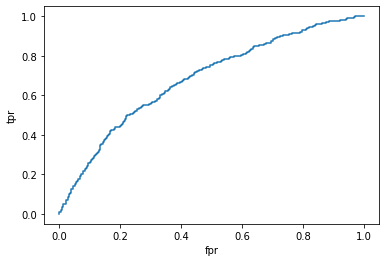

In [323]:
plt.plot(scores['fpr'],scores['tpr']);
plt.ylabel('tpr');
plt.xlabel('fpr');

In [308]:
auc_score = roc_auc_score(y['NEO_N'], y_pred_NEO_N)
auc_score

0.6323920352367798

## Building seperate models M and F models for each target

In [377]:
# Clean sex col- drop nan and convert to single char
sex_df = df
print(sex_df.sex.unique())
sex_df.sex.isnull().sum()
sex_df = sex_df[sex_df.sex.notnull()]
sex_df.sex.replace('female', 'F', inplace=True)
sex_df.sex.replace('male', 'M', inplace=True)
print(sex_df.sex.unique())
sex_df.shape

['F' 'M' nan]
['F' 'M']


(1353, 132)

In [378]:
# Make male and female df
f_df = sex_df[sex_df.sex=='F']
m_df = sex_df[sex_df.sex=='M']

In [379]:
# Feature creation
X_f = f_df.iloc[:,11:].reset_index(drop=True)
X_m = m_df.iloc[:,11:].reset_index(drop=True)

In [496]:
# Target creation: 0 = lower, 1 = higher
y_f_disc = f_df.iloc[:,6:11].reset_index(drop=True)
y_f = []
for i in range(5):
    y_f.append(pd.cut(x= y_f_disc.iloc[:,i], 
                    bins= [y_f_disc.iloc[:,i].min()-1, y_f_disc.iloc[:,i].mean(), y_f_disc.iloc[:,i].max()+1], 
                    labels= [0, 1]))
y_f = pd.DataFrame(y_f[0:5]).T.reset_index(drop=True)

y_m_disc = m_df.iloc[:,6:11].reset_index(drop=True)
y_m = []
for i in range(5):
    y_m.append(pd.cut(x= y_m_disc.iloc[:,i], 
                    bins= [y_m_disc.iloc[:,i].min()-1, y_m_disc.iloc[:,i].mean(), y_m_disc.iloc[:,i].max()+1], 
                    labels= [0, 1]))
y_m = pd.DataFrame(y_m[0:5]).T.reset_index(drop=True)

In [381]:
# Normalise features
scaler_f = StandardScaler()
X_f_scaled = scaler_f.fit_transform(X_f)

scaler_m = StandardScaler()
X_m_scaled = scaler_m.fit_transform(X_m)

In [383]:
# Add a constant as a feature to the scaled X
X_f_scaled_int = sm.add_constant(X_f_scaled)
X_f_scaled_int = pd.DataFrame(X_f_scaled_int, columns=X_int.columns)

X_m_scaled_int = sm.add_constant(X_m_scaled)
X_m_scaled_int = pd.DataFrame(X_m_scaled_int, columns=X_int.columns)

NEO_N

In [389]:
results_f_NEO_N = sm.Logit(y_f['NEO_N'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_N.summary()

Optimization terminated successfully.
         Current function value: 0.606942
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1232
Time:                        19:26:18   Log-Likelihood:                -441.25
converged:                       True   LL-Null:                       -503.26
Covariance Type:            nonrobust   LLR p-value:                    0.3823
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1069      0.081     -1.314      0.189      -0.266       0.053
lh_bankssts_thickness                     0.0698      0.117      0.595      0.552      -0.160       0.299
lh_caudalanteriorcingulate_thickness     -0.1063      0.114     -0.930      0.353      -0.330       0.118
lh_caudalmiddlefrontal_thickness         -0.0436      0.179     -0.244      0.807      -0.394       0.307
lh_cuneus_thickness                     6.59e-05      0.165      0.000      1.000      -0.323       0.323
lh_entorhinal_thickness                  -0.0282      0.113     -0.251      0.802      -0.249       0.193
lh_fusiform_thickness                     0.2020      0.164      1.235      0.217      -0.119       0.523
lh_inferiorparietal_thickness            -0.2068      0.200     -1.033      0.302      -0.599       0.186
lh_inferiortemporal_thickness            -0.2037      0.173     -1.174      0.240      -0.544       0.136
lh_isthmuscingulate_thickness            -0.0768      0.134     -0.573      0.567      -0.340       0.186
lh_lateraloccipital_thickness             0.0838      0.226      0.372      0.710      -0.358       0.526
lh_lateralorbitofrontal_thickness        -0.0353      0.149     -0.236      0.813      -0.328       0.258
lh_lingual_thickness                      0.0168      0.194      0.087      0.931      -0.364       0.398
lh_medialorbitofrontal_thickness         -0.0527      0.154     -0.343      0.731      -0.354       0.248
lh_middletemporal_thickness              -0.0646      0.176     -0.367      0.713      -0.409       0.280
lh_parahippocampal_thickness             -0.1203      0.131     -0.915      0.360      -0.378       0.137
lh_paracentral_thickness                  0.1091      0.151      0.725      0.469      -0.186       0.404
lh_parsopercularis_thickness             -0.2502      0.146     -1.714      0.087      -0.536       0.036
lh_parsorbitalis_thickness               -0.0525      0.127     -0.412      0.680      -0.302       0.197
lh_parstriangularis_thickness            -0.0116      0.147     -0.079      0.937      -0.300       0.276
lh_pericalcarine_thickness               -0.0063      0.173     -0.036      0.971      -0.346       0.333
lh_postcentral_thickness                 -0.0656      0.184     -0.356      0.722      -0.427       0.295
lh_posteriorcingulate_thickness          -0.0796      0.134     -0.595      0.552      -0.342       0.183
lh_precentral_thickness                  -0.1242      0.208     -0.598      0.550      -0.531       0.283
lh_precuneus_thickness                   -0.0066      0.190     -0.035      0.972      -0.380       0.366
lh_rostralanteriorcingulate_thickness     0.0165      0.113      0.145      0.884      -0.206       0.239
lh_rostralmiddlefrontal_thickness        -0.0678      0.236     -0.287      0.774      -0.531       0.395
lh_superiorfrontal_thickness             -0.5344      0.313  

In [390]:
results_m_NEO_N = sm.Logit(y_m['NEO_N'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_N.summary()

Optimization terminated successfully.
         Current function value: 0.541569
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_N   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.2186
Time:                        19:33:51   Log-Likelihood:                -339.02
converged:                       True   LL-Null:                       -433.86
Covariance Type:            nonrobust   LLR p-value:                 5.222e-05
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.0104      0.095     -0.109      0.913      -0.196       0.176
lh_bankssts_thickness                    -0.0869      0.139     -0.625      0.532      -0.360       0.186
lh_caudalanteriorcingulate_thickness      0.0970      0.124      0.783      0.434      -0.146       0.340
lh_caudalmiddlefrontal_thickness          0.4815      0.215      2.241      0.025       0.060       0.903
lh_cuneus_thickness                      -0.1562      0.182     -0.858      0.391      -0.513       0.201
lh_entorhinal_thickness                  -0.0878      0.133     -0.662      0.508      -0.348       0.172
lh_fusiform_thickness                    -0.1388      0.190     -0.730      0.465      -0.511       0.234
lh_inferiorparietal_thickness             0.1276      0.223      0.571      0.568      -0.310       0.565
lh_inferiortemporal_thickness            -0.0704      0.215     -0.328      0.743      -0.492       0.351
lh_isthmuscingulate_thickness             0.0888      0.143      0.619      0.536      -0.192       0.370
lh_lateraloccipital_thickness            -0.1265      0.246     -0.514      0.607      -0.608       0.355
lh_lateralorbitofrontal_thickness         0.4394      0.184      2.388      0.017       0.079       0.800
lh_lingual_thickness                      0.0112      0.207      0.054      0.957      -0.394       0.416
lh_medialorbitofrontal_thickness          0.0602      0.161      0.373      0.709      -0.256       0.377
lh_middletemporal_thickness               0.1716      0.216      0.793      0.428      -0.253       0.596
lh_parahippocampal_thickness             -0.2811      0.162     -1.731      0.083      -0.599       0.037
lh_paracentral_thickness                  0.0890      0.173      0.515      0.607      -0.250       0.428
lh_parsopercularis_thickness              0.1719      0.168      1.020      0.308      -0.158       0.502
lh_parsorbitalis_thickness               -0.0576      0.158     -0.365      0.715      -0.367       0.252
lh_parstriangularis_thickness            -0.2138      0.176     -1.211      0.226      -0.560       0.132
lh_pericalcarine_thickness                0.4189      0.199      2.108      0.035       0.029       0.808
lh_postcentral_thickness                  0.5065      0.205      2.471      0.013       0.105       0.908
lh_posteriorcingulate_thickness          -0.1752      0.149     -1.179      0.238      -0.466       0.116
lh_precentral_thickness                  -0.5049      0.238     -2.122      0.034      -0.971      -0.039
lh_precuneus_thickness                    0.2426      0.221      1.098      0.272      -0.191       0.676
lh_rostralanteriorcingulate_thickness    -0.1076      0.130     -0.831      0.406      -0.362       0.146
lh_rostralmiddlefrontal_thickness         0.2073      0.273      0.760      0.447      -0.327       0.742
lh_superiorfrontal_thickness             -0.2025      0.342  

In [393]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_N = results_f_NEO_N.predict(X_f_scaled_int)
y_pred_m_proba_NEO_N = results_m_NEO_N.predict(X_m_scaled_int)

y_pred_f_NEO_N = results_f_NEO_N.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_N = results_m_NEO_N.predict(X_m_scaled_int)>0.5

In [394]:
# Print classification reports
print(classification_report(y_f['NEO_N'], y_pred_f_NEO_N))
print(classification_report(y_m['NEO_N'], y_pred_m_NEO_N))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67       379
           1       0.64      0.63      0.63       348

    accuracy                           0.65       727
   macro avg       0.65      0.65      0.65       727
weighted avg       0.65      0.65      0.65       727

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       317
           1       0.71      0.71      0.71       309

    accuracy                           0.72       626
   macro avg       0.72      0.72      0.72       626
weighted avg       0.72      0.72      0.72       626



In [407]:
auc_f_NEO_N_score = roc_auc_score(y_f['NEO_N'], y_pred_f_NEO_N)
auc_m_NEO_N_score = roc_auc_score(y_m['NEO_N'], y_pred_m_NEO_N)
print(auc_f_NEO_N_score)
auc_m_NEO_N_score

0.6511843023079489


0.7155268342980816

NEO_E

In [413]:
results_f_NEO_E = sm.Logit(y_f['NEO_E'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_E.summary()

Optimization terminated successfully.
         Current function value: 0.574548
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_E   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1710
Time:                        20:52:03   Log-Likelihood:                -417.70
converged:                       True   LL-Null:                       -503.88
Covariance Type:            nonrobust   LLR p-value:                  0.001234
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0282      0.084      0.334      0.738      -0.137       0.194
lh_bankssts_thickness                     0.0232      0.122      0.190      0.850      -0.216       0.262
lh_caudalanteriorcingulate_thickness      0.0971      0.119      0.814      0.416      -0.137       0.331
lh_caudalmiddlefrontal_thickness         -0.1892      0.186     -1.019      0.308      -0.553       0.175
lh_cuneus_thickness                      -0.1267      0.173     -0.731      0.465      -0.466       0.213
lh_entorhinal_thickness                   0.1740      0.116      1.501      0.133      -0.053       0.401
lh_fusiform_thickness                    -0.0309      0.171     -0.180      0.857      -0.367       0.305
lh_inferiorparietal_thickness             0.1654      0.212      0.781      0.435      -0.250       0.581
lh_inferiortemporal_thickness            -0.0187      0.180     -0.104      0.917      -0.371       0.334
lh_isthmuscingulate_thickness            -0.0294      0.139     -0.211      0.833      -0.303       0.244
lh_lateraloccipital_thickness             0.1732      0.231      0.749      0.454      -0.280       0.626
lh_lateralorbitofrontal_thickness         0.1670      0.157      1.062      0.288      -0.141       0.475
lh_lingual_thickness                      0.0375      0.201      0.187      0.852      -0.356       0.431
lh_medialorbitofrontal_thickness          0.1044      0.159      0.656      0.512      -0.208       0.416
lh_middletemporal_thickness               0.3160      0.182      1.733      0.083      -0.041       0.673
lh_parahippocampal_thickness              0.1020      0.137      0.745      0.456      -0.166       0.370
lh_paracentral_thickness                 -0.1719      0.156     -1.101      0.271      -0.478       0.134
lh_parsopercularis_thickness              0.2219      0.152      1.465      0.143      -0.075       0.519
lh_parsorbitalis_thickness               -0.1049      0.131     -0.802      0.422      -0.361       0.151
lh_parstriangularis_thickness             0.1722      0.152      1.131      0.258      -0.126       0.471
lh_pericalcarine_thickness               -0.1543      0.179     -0.863      0.388      -0.505       0.196
lh_postcentral_thickness                  0.3967      0.194      2.041      0.041       0.016       0.778
lh_posteriorcingulate_thickness          -0.0470      0.142     -0.332      0.740      -0.324       0.231
lh_precentral_thickness                   0.5817      0.214      2.712      0.007       0.161       1.002
lh_precuneus_thickness                    0.5033      0.200      2.521      0.012       0.112       0.895
lh_rostralanteriorcingulate_thickness     0.0880      0.115      0.767      0.443      -0.137       0.313
lh_rostralmiddlefrontal_thickness        -0.0999      0.242     -0.413      0.680      -0.574       0.374
lh_superiorfrontal_thickness              0.5217      0.327  

In [414]:
results_m_NEO_E = sm.Logit(y_m['NEO_E'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_E.summary()

Optimization terminated successfully.
         Current function value: 0.569073
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_E   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1749
Time:                        20:52:06   Log-Likelihood:                -356.24
converged:                       True   LL-Null:                       -431.75
Covariance Type:            nonrobust   LLR p-value:                   0.02912
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2240      0.093      2.404      0.016       0.041       0.407
lh_bankssts_thickness                     0.0381      0.132      0.288      0.773      -0.221       0.297
lh_caudalanteriorcingulate_thickness      0.0627      0.122      0.516      0.606      -0.175       0.301
lh_caudalmiddlefrontal_thickness         -0.0130      0.207     -0.063      0.950      -0.419       0.393
lh_cuneus_thickness                      -0.0007      0.176     -0.004      0.997      -0.346       0.345
lh_entorhinal_thickness                   0.2463      0.129      1.912      0.056      -0.006       0.499
lh_fusiform_thickness                     0.0572      0.181      0.316      0.752      -0.298       0.413
lh_inferiorparietal_thickness            -0.0101      0.214     -0.047      0.962      -0.430       0.410
lh_inferiortemporal_thickness             0.0522      0.205      0.255      0.799      -0.349       0.453
lh_isthmuscingulate_thickness             0.0660      0.138      0.479      0.632      -0.204       0.336
lh_lateraloccipital_thickness             0.4566      0.241      1.893      0.058      -0.016       0.929
lh_lateralorbitofrontal_thickness         0.3769      0.176      2.147      0.032       0.033       0.721
lh_lingual_thickness                     -0.0030      0.203     -0.015      0.988      -0.402       0.396
lh_medialorbitofrontal_thickness         -0.1656      0.154     -1.074      0.283      -0.468       0.136
lh_middletemporal_thickness               0.0176      0.208      0.085      0.933      -0.390       0.425
lh_parahippocampal_thickness              0.3375      0.152      2.222      0.026       0.040       0.635
lh_paracentral_thickness                  0.0360      0.169      0.213      0.832      -0.296       0.368
lh_parsopercularis_thickness             -0.1738      0.161     -1.082      0.279      -0.489       0.141
lh_parsorbitalis_thickness                0.0021      0.154      0.014      0.989      -0.300       0.304
lh_parstriangularis_thickness            -0.1275      0.171     -0.746      0.456      -0.462       0.208
lh_pericalcarine_thickness               -0.0649      0.182     -0.356      0.722      -0.422       0.293
lh_postcentral_thickness                  0.1456      0.197      0.741      0.459      -0.240       0.531
lh_posteriorcingulate_thickness          -0.1511      0.144     -1.052      0.293      -0.433       0.130
lh_precentral_thickness                   0.6443      0.232      2.782      0.005       0.190       1.098
lh_precuneus_thickness                    0.0717      0.218      0.329      0.742      -0.356       0.499
lh_rostralanteriorcingulate_thickness    -0.0937      0.126     -0.743      0.457      -0.341       0.153
lh_rostralmiddlefrontal_thickness        -0.0131      0.270     -0.048      0.961      -0.541       0.515
lh_superiorfrontal_thickness              0.3058      0.322  

In [418]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_E = results_f_NEO_E.predict(X_f_scaled_int)
y_pred_m_proba_NEO_E = results_m_NEO_E.predict(X_m_scaled_int)
y_pred_f_NEO_E = results_f_NEO_E.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_E = results_m_NEO_E.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_E'], y_pred_f_NEO_E))
print(classification_report(y_m['NEO_E'], y_pred_m_NEO_E))
auc_f_NEO_E_score = roc_auc_score(y_f['NEO_E'], y_pred_f_NEO_E)
auc_m_NEO_E_score = roc_auc_score(y_m['NEO_E'], y_pred_m_NEO_E)
print(auc_f_NEO_E_score)
auc_m_NEO_E_score

              precision    recall  f1-score   support

           0       0.69      0.68      0.68       360
           1       0.69      0.69      0.69       367

    accuracy                           0.69       727
   macro avg       0.69      0.69      0.69       727
weighted avg       0.69      0.69      0.69       727

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       287
           1       0.70      0.73      0.72       339

    accuracy                           0.69       626
   macro avg       0.68      0.68      0.68       626
weighted avg       0.69      0.69      0.69       626

0.6876892219194671


0.6833893496962783

NEO_O

In [419]:
results_f_NEO_O = sm.Logit(y_f['NEO_O'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_O.summary()

Optimization terminated successfully.
         Current function value: 0.572967
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_O   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1732
Time:                        20:53:49   Log-Likelihood:                -416.55
converged:                       True   LL-Null:                       -503.80
Covariance Type:            nonrobust   LLR p-value:                 0.0008582
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0431      0.085      0.510      0.610      -0.123       0.209
lh_bankssts_thickness                     0.0642      0.123      0.521      0.602      -0.177       0.306
lh_caudalanteriorcingulate_thickness      0.0774      0.120      0.647      0.518      -0.157       0.312
lh_caudalmiddlefrontal_thickness         -0.1074      0.190     -0.565      0.572      -0.480       0.265
lh_cuneus_thickness                      -0.2948      0.173     -1.704      0.088      -0.634       0.044
lh_entorhinal_thickness                   0.1255      0.117      1.075      0.282      -0.103       0.354
lh_fusiform_thickness                    -0.3528      0.170     -2.075      0.038      -0.686      -0.020
lh_inferiorparietal_thickness             0.3182      0.207      1.535      0.125      -0.088       0.724
lh_inferiortemporal_thickness            -0.1125      0.182     -0.619      0.536      -0.469       0.244
lh_isthmuscingulate_thickness             0.0097      0.139      0.070      0.944      -0.263       0.283
lh_lateraloccipital_thickness            -0.2102      0.237     -0.888      0.375      -0.674       0.254
lh_lateralorbitofrontal_thickness         0.0150      0.155      0.097      0.923      -0.289       0.319
lh_lingual_thickness                     -0.0437      0.203     -0.215      0.830      -0.442       0.355
lh_medialorbitofrontal_thickness          0.0148      0.161      0.092      0.927      -0.301       0.331
lh_middletemporal_thickness              -0.1484      0.184     -0.806      0.420      -0.509       0.213
lh_parahippocampal_thickness             -0.1879      0.137     -1.368      0.171      -0.457       0.081
lh_paracentral_thickness                 -0.0692      0.156     -0.442      0.658      -0.376       0.237
lh_parsopercularis_thickness              0.1986      0.152      1.303      0.193      -0.100       0.497
lh_parsorbitalis_thickness               -0.2634      0.134     -1.966      0.049      -0.526      -0.001
lh_parstriangularis_thickness            -0.0631      0.153     -0.412      0.680      -0.363       0.237
lh_pericalcarine_thickness                0.0212      0.181      0.117      0.907      -0.334       0.376
lh_postcentral_thickness                 -0.0409      0.194     -0.211      0.833      -0.421       0.340
lh_posteriorcingulate_thickness           0.1920      0.140      1.374      0.169      -0.082       0.466
lh_precentral_thickness                   0.1914      0.211      0.907      0.364      -0.222       0.605
lh_precuneus_thickness                    0.3856      0.197      1.961      0.050       0.000       0.771
lh_rostralanteriorcingulate_thickness    -0.0662      0.119     -0.554      0.579      -0.300       0.168
lh_rostralmiddlefrontal_thickness         0.1225      0.242      0.507      0.612      -0.351       0.596
lh_superiorfrontal_thickness              0.2417      0.328  

In [420]:
results_m_NEO_O = sm.Logit(y_m['NEO_O'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_O.summary()

Optimization terminated successfully.
         Current function value: 0.578433
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_O   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1650
Time:                        20:53:50   Log-Likelihood:                -362.10
converged:                       True   LL-Null:                       -433.65
Covariance Type:            nonrobust   LLR p-value:                   0.07387
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0737      0.091      0.813      0.416      -0.104       0.251
lh_bankssts_thickness                     0.1088      0.131      0.829      0.407      -0.148       0.366
lh_caudalanteriorcingulate_thickness      0.0670      0.120      0.560      0.575      -0.167       0.301
lh_caudalmiddlefrontal_thickness          0.2881      0.206      1.395      0.163      -0.117       0.693
lh_cuneus_thickness                      -0.0322      0.175     -0.184      0.854      -0.376       0.311
lh_entorhinal_thickness                   0.1499      0.126      1.187      0.235      -0.098       0.397
lh_fusiform_thickness                     0.3773      0.184      2.052      0.040       0.017       0.738
lh_inferiorparietal_thickness            -0.0462      0.212     -0.218      0.827      -0.462       0.369
lh_inferiortemporal_thickness             0.2357      0.205      1.148      0.251      -0.167       0.638
lh_isthmuscingulate_thickness            -0.0152      0.139     -0.110      0.913      -0.287       0.257
lh_lateraloccipital_thickness            -0.2329      0.236     -0.988      0.323      -0.695       0.229
lh_lateralorbitofrontal_thickness         0.5080      0.176      2.881      0.004       0.162       0.854
lh_lingual_thickness                      0.0907      0.197      0.460      0.646      -0.296       0.477
lh_medialorbitofrontal_thickness         -0.0460      0.156     -0.294      0.769      -0.353       0.261
lh_middletemporal_thickness              -0.3316      0.203     -1.632      0.103      -0.730       0.067
lh_parahippocampal_thickness             -0.1229      0.152     -0.806      0.420      -0.422       0.176
lh_paracentral_thickness                  0.2701      0.165      1.641      0.101      -0.053       0.593
lh_parsopercularis_thickness             -0.1393      0.158     -0.880      0.379      -0.450       0.171
lh_parsorbitalis_thickness                0.1453      0.153      0.949      0.343      -0.155       0.445
lh_parstriangularis_thickness             0.1421      0.168      0.844      0.399      -0.188       0.472
lh_pericalcarine_thickness                0.2091      0.185      1.129      0.259      -0.154       0.572
lh_postcentral_thickness                  0.0953      0.194      0.490      0.624      -0.286       0.476
lh_posteriorcingulate_thickness           0.0853      0.144      0.592      0.554      -0.197       0.368
lh_precentral_thickness                  -0.0711      0.226     -0.314      0.753      -0.514       0.372
lh_precuneus_thickness                    0.0665      0.211      0.315      0.753      -0.347       0.480
lh_rostralanteriorcingulate_thickness    -0.1043      0.126     -0.826      0.409      -0.352       0.143
lh_rostralmiddlefrontal_thickness         0.3013      0.270      1.116      0.264      -0.228       0.830
lh_superiorfrontal_thickness             -0.1906      0.325  

In [422]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_O = results_f_NEO_O.predict(X_f_scaled_int)
y_pred_m_proba_NEO_O = results_m_NEO_O.predict(X_m_scaled_int)
y_pred_f_NEO_O = results_f_NEO_O.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_O = results_m_NEO_O.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_O'], y_pred_f_NEO_O))
print(classification_report(y_m['NEO_O'], y_pred_m_NEO_O))
auc_f_NEO_O_score = roc_auc_score(y_f['NEO_O'], y_pred_f_NEO_O)
auc_m_NEO_O_score = roc_auc_score(y_m['NEO_O'], y_pred_m_NEO_O)
print(auc_f_NEO_O_score)
auc_m_NEO_O_score

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       357
           1       0.70      0.72      0.71       370

    accuracy                           0.70       727
   macro avg       0.70      0.70      0.70       727
weighted avg       0.70      0.70      0.70       727

              precision    recall  f1-score   support

           0       0.68      0.65      0.67       304
           1       0.68      0.70      0.69       322

    accuracy                           0.68       626
   macro avg       0.68      0.68      0.68       626
weighted avg       0.68      0.68      0.68       626

0.698345824816413


0.6797871036286368

NEO_A

In [423]:
results_f_NEO_A = sm.Logit(y_f['NEO_A'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_A.summary()

Optimization terminated successfully.
         Current function value: 0.581231
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_A   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1527
Time:                        20:54:11   Log-Likelihood:                -422.56
converged:                       True   LL-Null:                       -498.70
Covariance Type:            nonrobust   LLR p-value:                   0.02475
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.3144      0.085      3.709      0.000       0.148       0.481
lh_bankssts_thickness                    -0.0869      0.121     -0.720      0.472      -0.324       0.150
lh_caudalanteriorcingulate_thickness     -0.0965      0.120     -0.807      0.420      -0.331       0.138
lh_caudalmiddlefrontal_thickness         -0.0222      0.187     -0.119      0.905      -0.388       0.344
lh_cuneus_thickness                      -0.0347      0.171     -0.203      0.839      -0.369       0.300
lh_entorhinal_thickness                  -0.1510      0.116     -1.300      0.194      -0.379       0.077
lh_fusiform_thickness                    -0.0490      0.170     -0.287      0.774      -0.383       0.285
lh_inferiorparietal_thickness             0.3178      0.205      1.547      0.122      -0.085       0.720
lh_inferiortemporal_thickness            -0.1858      0.180     -1.033      0.302      -0.538       0.167
lh_isthmuscingulate_thickness            -0.0977      0.138     -0.711      0.477      -0.367       0.172
lh_lateraloccipital_thickness            -0.2084      0.229     -0.910      0.363      -0.657       0.240
lh_lateralorbitofrontal_thickness         0.0232      0.154      0.150      0.881      -0.279       0.326
lh_lingual_thickness                      0.0730      0.201      0.363      0.717      -0.321       0.467
lh_medialorbitofrontal_thickness         -0.2000      0.158     -1.268      0.205      -0.509       0.109
lh_middletemporal_thickness               0.0224      0.182      0.123      0.902      -0.333       0.378
lh_parahippocampal_thickness              0.0335      0.136      0.246      0.806      -0.234       0.301
lh_paracentral_thickness                 -0.1705      0.154     -1.105      0.269      -0.473       0.132
lh_parsopercularis_thickness             -0.2821      0.150     -1.886      0.059      -0.575       0.011
lh_parsorbitalis_thickness               -0.0726      0.131     -0.555      0.579      -0.329       0.184
lh_parstriangularis_thickness            -0.0600      0.153     -0.392      0.695      -0.360       0.240
lh_pericalcarine_thickness                0.2381      0.177      1.345      0.179      -0.109       0.585
lh_postcentral_thickness                 -0.1317      0.190     -0.695      0.487      -0.503       0.240
lh_posteriorcingulate_thickness           0.0023      0.139      0.016      0.987      -0.270       0.275
lh_precentral_thickness                   0.3215      0.212      1.519      0.129      -0.093       0.736
lh_precuneus_thickness                    0.0084      0.195      0.043      0.966      -0.373       0.390
lh_rostralanteriorcingulate_thickness     0.0687      0.116      0.595      0.552      -0.158       0.295
lh_rostralmiddlefrontal_thickness         0.3050      0.241      1.264      0.206      -0.168       0.778
lh_superiorfrontal_thickness             -0.4532      0.322  

In [424]:
results_m_NEO_A = sm.Logit(y_m['NEO_A'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_A.summary()

Optimization terminated successfully.
         Current function value: 0.562276
         Iterations 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_A   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.1847
Time:                        20:54:12   Log-Likelihood:                -351.98
converged:                       True   LL-Null:                       -431.75
Covariance Type:            nonrobust   LLR p-value:                  0.009206
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2482      0.094      2.641      0.008       0.064       0.432
lh_bankssts_thickness                     0.0682      0.133      0.512      0.609      -0.193       0.329
lh_caudalanteriorcingulate_thickness      0.1929      0.126      1.525      0.127      -0.055       0.441
lh_caudalmiddlefrontal_thickness          0.1660      0.209      0.792      0.428      -0.245       0.577
lh_cuneus_thickness                      -0.0070      0.179     -0.039      0.969      -0.358       0.344
lh_entorhinal_thickness                   0.0057      0.127      0.045      0.964      -0.243       0.255
lh_fusiform_thickness                    -0.2899      0.186     -1.556      0.120      -0.655       0.075
lh_inferiorparietal_thickness             0.0610      0.218      0.280      0.780      -0.366       0.488
lh_inferiortemporal_thickness             0.5693      0.213      2.671      0.008       0.152       0.987
lh_isthmuscingulate_thickness            -0.0477      0.139     -0.344      0.731      -0.319       0.224
lh_lateraloccipital_thickness             0.1223      0.242      0.506      0.613      -0.351       0.596
lh_lateralorbitofrontal_thickness         0.2227      0.176      1.269      0.205      -0.121       0.567
lh_lingual_thickness                      0.1867      0.197      0.948      0.343      -0.199       0.573
lh_medialorbitofrontal_thickness         -0.0210      0.159     -0.132      0.895      -0.333       0.291
lh_middletemporal_thickness              -0.2934      0.211     -1.388      0.165      -0.708       0.121
lh_parahippocampal_thickness             -0.1504      0.153     -0.980      0.327      -0.451       0.150
lh_paracentral_thickness                 -0.0935      0.169     -0.552      0.581      -0.426       0.239
lh_parsopercularis_thickness              0.0191      0.162      0.118      0.906      -0.299       0.337
lh_parsorbitalis_thickness                0.1924      0.156      1.233      0.218      -0.114       0.498
lh_parstriangularis_thickness             0.1485      0.173      0.858      0.391      -0.191       0.488
lh_pericalcarine_thickness               -0.4758      0.191     -2.486      0.013      -0.851      -0.101
lh_postcentral_thickness                  0.0416      0.199      0.209      0.835      -0.349       0.432
lh_posteriorcingulate_thickness           0.0932      0.144      0.647      0.518      -0.189       0.376
lh_precentral_thickness                  -0.1881      0.229     -0.822      0.411      -0.636       0.260
lh_precuneus_thickness                    0.3789      0.219      1.730      0.084      -0.050       0.808
lh_rostralanteriorcingulate_thickness    -0.1072      0.130     -0.822      0.411      -0.363       0.148
lh_rostralmiddlefrontal_thickness         0.3472      0.275      1.263      0.206      -0.192       0.886
lh_superiorfrontal_thickness              0.0251      0.333  

In [425]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_A = results_f_NEO_A.predict(X_f_scaled_int)
y_pred_m_proba_NEO_A = results_m_NEO_A.predict(X_m_scaled_int)
y_pred_f_NEO_A = results_f_NEO_A.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_A = results_m_NEO_A.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_A'], y_pred_f_NEO_A))
print(classification_report(y_m['NEO_A'], y_pred_m_NEO_A))
auc_f_NEO_A_score = roc_auc_score(y_f['NEO_A'], y_pred_f_NEO_A)
auc_m_NEO_A_score = roc_auc_score(y_m['NEO_A'], y_pred_m_NEO_A)
print(auc_f_NEO_A_score)
auc_m_NEO_A_score

              precision    recall  f1-score   support

           0       0.67      0.62      0.65       320
           1       0.72      0.76      0.74       407

    accuracy                           0.70       727
   macro avg       0.70      0.69      0.69       727
weighted avg       0.70      0.70      0.70       727

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       287
           1       0.74      0.75      0.75       339

    accuracy                           0.72       626
   macro avg       0.72      0.72      0.72       626
weighted avg       0.72      0.72      0.72       626

0.6917728808353808


0.7193117696031576

NEO_C

In [426]:
results_f_NEO_C = sm.Logit(y_f['NEO_C'], X_f_scaled_int).fit(maxiter=100)
results_f_NEO_C.summary()

         Current function value: 0.540476
         Iterations: 100


/Users/DrV/.pyenv/versions/3.8.6/envs/mri_personality/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_C   No. Observations:                  727
Model:                          Logit   Df Residuals:                      606
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.2202
Time:                        20:54:34   Log-Likelihood:                -392.93
converged:                      False   LL-Null:                       -503.86
Covariance Type:            nonrobust   LLR p-value:                 4.562e-08
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2337   2015.447      0.000      1.000   -3949.969    3950.436
lh_bankssts_thickness                     0.0521      0.128      0.409      0.683      -0.198       0.302
lh_caudalanteriorcingulate_thickness      0.1814      0.125      1.454      0.146      -0.063       0.426
lh_caudalmiddlefrontal_thickness         -0.4314      0.194     -2.219      0.027      -0.812      -0.050
lh_cuneus_thickness                       0.0579      0.180      0.321      0.748      -0.296       0.412
lh_entorhinal_thickness                   0.3278      0.123      2.674      0.008       0.087       0.568
lh_fusiform_thickness                    -0.0882      0.178     -0.495      0.621      -0.438       0.261
lh_inferiorparietal_thickness             0.1635      0.213      0.766      0.444      -0.255       0.582
lh_inferiortemporal_thickness             0.1628      0.192      0.846      0.397      -0.214       0.540
lh_isthmuscingulate_thickness            -0.0814      0.143     -0.567      0.571      -0.363       0.200
lh_lateraloccipital_thickness            -0.1770      0.241     -0.735      0.463      -0.649       0.295
lh_lateralorbitofrontal_thickness        -0.2718      0.163     -1.670      0.095      -0.591       0.047
lh_lingual_thickness                     -0.3641      0.210     -1.734      0.083      -0.776       0.048
lh_medialorbitofrontal_thickness          0.0500      0.164      0.305      0.761      -0.271       0.371
lh_middletemporal_thickness              -0.2158      0.189     -1.139      0.255      -0.587       0.155
lh_parahippocampal_thickness              0.0773      0.142      0.545      0.586      -0.201       0.355
lh_paracentral_thickness                  0.0572      0.162      0.353      0.724      -0.260       0.374
lh_parsopercularis_thickness             -0.0728      0.156     -0.465      0.642      -0.379       0.234
lh_parsorbitalis_thickness                0.0833      0.136      0.614      0.539      -0.183       0.349
lh_parstriangularis_thickness             0.0474      0.156      0.304      0.761      -0.259       0.353
lh_pericalcarine_thickness               -0.0096      0.184     -0.052      0.959      -0.371       0.352
lh_postcentral_thickness                  0.1749      0.202      0.864      0.388      -0.222       0.571
lh_posteriorcingulate_thickness           0.0411      0.146      0.281      0.779      -0.245       0.328
lh_precentral_thickness                  -0.0710      0.222     -0.320      0.749      -0.506       0.364
lh_precuneus_thickness                    0.3537      0.205      1.724      0.085      -0.048       0.756
lh_rostralanteriorcingulate_thickness     0.1109      0.121      0.918      0.359      -0.126       0.348
lh_rostralmiddlefrontal_thickness         0.2085      0.250      0.834      0.404      -0.281       0.698
lh_superiorfrontal_thickness              0.1493      0.339  

In [427]:
results_m_NEO_C = sm.Logit(y_m['NEO_C'], X_m_scaled_int).fit(maxiter=100)
results_m_NEO_C.summary()

Optimization terminated successfully.
         Current function value: 0.539127
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  NEO_C   No. Observations:                  626
Model:                          Logit   Df Residuals:                      505
Method:                           MLE   Df Model:                          120
Date:                Fri, 20 Aug 2021   Pseudo R-squ.:                  0.2221
Time:                        20:54:40   Log-Likelihood:                -337.49
converged:                       True   LL-Null:                       -433.86
Covariance Type:            nonrobust   LLR p-value:                 2.843e-05
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.0423      0.096      0.442      0.659      -0.145       0.230
lh_bankssts_thickness                    -0.3562      0.138     -2.583      0.010      -0.627      -0.086
lh_caudalanteriorcingulate_thickness      0.0169      0.125      0.135      0.893      -0.229       0.263
lh_caudalmiddlefrontal_thickness          0.0601      0.218      0.276      0.783      -0.367       0.488
lh_cuneus_thickness                      -0.0551      0.186     -0.296      0.768      -0.420       0.310
lh_entorhinal_thickness                   0.2456      0.132      1.864      0.062      -0.013       0.504
lh_fusiform_thickness                     0.2549      0.190      1.339      0.181      -0.118       0.628
lh_inferiorparietal_thickness            -0.0332      0.222     -0.149      0.881      -0.468       0.402
lh_inferiortemporal_thickness            -0.0388      0.215     -0.180      0.857      -0.461       0.383
lh_isthmuscingulate_thickness            -0.0189      0.146     -0.130      0.897      -0.304       0.267
lh_lateraloccipital_thickness            -0.2865      0.249     -1.151      0.250      -0.774       0.201
lh_lateralorbitofrontal_thickness        -0.1418      0.183     -0.777      0.437      -0.500       0.216
lh_lingual_thickness                      0.3376      0.207      1.633      0.102      -0.068       0.743
lh_medialorbitofrontal_thickness         -0.1216      0.164     -0.742      0.458      -0.443       0.200
lh_middletemporal_thickness              -0.0718      0.215     -0.333      0.739      -0.494       0.351
lh_parahippocampal_thickness              0.1091      0.159      0.687      0.492      -0.202       0.420
lh_paracentral_thickness                 -0.0110      0.173     -0.064      0.949      -0.350       0.328
lh_parsopercularis_thickness              0.0517      0.171      0.302      0.763      -0.284       0.387
lh_parsorbitalis_thickness               -0.0051      0.163     -0.031      0.975      -0.325       0.314
lh_parstriangularis_thickness            -0.3047      0.177     -1.722      0.085      -0.652       0.042
lh_pericalcarine_thickness               -0.3103      0.196     -1.581      0.114      -0.695       0.074
lh_postcentral_thickness                  0.0357      0.205      0.174      0.862      -0.367       0.438
lh_posteriorcingulate_thickness           0.3067      0.153      2.004      0.045       0.007       0.607
lh_precentral_thickness                  -0.1973      0.231     -0.854      0.393      -0.650       0.256
lh_precuneus_thickness                   -0.4432      0.219     -2.028      0.043      -0.872      -0.015
lh_rostralanteriorcingulate_thickness    -0.0735      0.134     -0.548      0.584      -0.336       0.189
lh_rostralmiddlefrontal_thickness         0.4865      0.284      1.716      0.086      -0.069       1.042
lh_superiorfrontal_thickness             -0.2738      0.339  

In [428]:
# Make y pred and y pred proba for the models
y_pred_f_proba_NEO_C = results_f_NEO_C.predict(X_f_scaled_int)
y_pred_m_proba_NEO_C = results_m_NEO_C.predict(X_m_scaled_int)
y_pred_f_NEO_C = results_f_NEO_C.predict(X_f_scaled_int)>0.5
y_pred_m_NEO_C = results_m_NEO_C.predict(X_m_scaled_int)>0.5
# Print classification reports
print(classification_report(y_f['NEO_C'], y_pred_f_NEO_C))
print(classification_report(y_m['NEO_C'], y_pred_m_NEO_C))
auc_f_NEO_C_score = roc_auc_score(y_f['NEO_C'], y_pred_f_NEO_C)
auc_m_NEO_C_score = roc_auc_score(y_m['NEO_C'], y_pred_m_NEO_C)
print(auc_f_NEO_C_score)
auc_m_NEO_C_score

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       368
           1       0.74      0.68      0.71       359

    accuracy                           0.72       727
   macro avg       0.72      0.72      0.72       727
weighted avg       0.72      0.72      0.72       727

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       309
           1       0.74      0.72      0.73       317

    accuracy                           0.73       626
   macro avg       0.73      0.73      0.73       626
weighted avg       0.73      0.73      0.73       626

0.7216604093496427


0.733367022959991

## Feature selection

Show the most important features for each target

In [452]:
NEO_N_f_best_feats = pd.DataFrame([results_f_NEO_N.params, results_f_NEO_N.pvalues], index=['coef', 'p-value']).T
NEO_N_f_best_feats[NEO_N_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_inferiorparietal_thickness,0.680723,0.004122
rh_superiortemporal_thickness,0.659949,0.003842
rh_caudalmiddlefrontal_thickness,0.488085,0.011560
rh_rostralmiddlefrontal_thickness,0.458638,0.049064
lh_frontalpole_thickness,-0.214385,0.039067
Right-vessel,-0.226084,0.032537
CC_Anterior,-0.398078,0.002878
rh_MeanThickness_thickness,-3.206932,0.032554


In [451]:
NEO_N_m_best_feats = pd.DataFrame([results_m_NEO_N.params, results_m_NEO_N.pvalues], index=['coef', 'p-value']).T
NEO_N_m_best_feats[NEO_N_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Putamen,1.226167,0.002156
Right-Thalamus-Proper,0.998181,0.027834
Right-VentralDC,0.949991,0.011799
Left-Caudate,0.815707,0.015307
Left-Hippocampus,0.771910,0.012652
rh_superiorfrontal_thickness,0.763971,0.017087
rh_superiorparietal_thickness,0.636964,0.034512
rh_lateraloccipital_thickness,0.561852,0.017138
rh_superiortemporal_thickness,0.540967,0.023359
lh_postcentral_thickness,0.506518,0.013475


In [453]:
NEO_E_f_best_feats = pd.DataFrame([results_f_NEO_E.params, results_f_NEO_E.pvalues], index=['coef', 'p-value']).T
NEO_E_f_best_feats[NEO_E_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
lh_precentral_thickness,0.581720,0.006684
lh_precuneus_thickness,0.503308,0.011708
Right-choroid-plexus,0.459772,0.006218
lh_postcentral_thickness,0.396695,0.041240
CC_Anterior,-0.276763,0.045280
WM-hypointensities,-0.304309,0.034821
Left-choroid-plexus,-0.366739,0.026199
rh_lateraloccipital_thickness,-0.522912,0.014149
rh_postcentral_thickness,-0.533191,0.006815
rh_inferiorparietal_thickness,-0.565461,0.022222


In [454]:
NEO_E_m_best_feats = pd.DataFrame([results_m_NEO_E.params, results_m_NEO_E.pvalues], index=['coef', 'p-value']).T
NEO_E_m_best_feats[NEO_E_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
SubCortGrayVol,5.918317,0.018465
eTIV,2.169573,0.015745
MaskVol-to-eTIV,1.290700,0.022001
lh_precentral_thickness,0.644339,0.005407
lh_supramarginal_thickness,0.537399,0.008574
Optic-Chiasm,0.467495,0.011669
rh_superiortemporal_thickness,0.462090,0.042694
rh_parstriangularis_thickness,0.454026,0.013940
lh_lateralorbitofrontal_thickness,0.376931,0.031813
lh_parahippocampal_thickness,0.337516,0.026303


In [455]:
NEO_O_f_best_feats = pd.DataFrame([results_f_NEO_O.params, results_f_NEO_O.pvalues], index=['coef', 'p-value']).T
NEO_O_f_best_feats[NEO_O_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Right-Pallidum,0.570696,0.034797
rh_transversetemporal_thickness,0.418839,0.001402
lh_insula_thickness,0.416475,0.005060
lh_precuneus_thickness,0.385624,0.049852
CSF,0.346108,0.017420
lh_parsorbitalis_thickness,-0.263386,0.049347
lh_transversetemporal_thickness,-0.279152,0.028465
Left-Inf-Lat-Vent,-0.295894,0.016548
lh_fusiform_thickness,-0.352775,0.037998
Left-Pallidum,-0.917862,0.000267


In [456]:
NEO_O_m_best_feats = pd.DataFrame([results_m_NEO_O.params, results_m_NEO_O.pvalues], index=['coef', 'p-value']).T
NEO_O_m_best_feats[NEO_O_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
eTIV,3.607364,0.000061
MaskVol-to-eTIV,2.423706,0.000017
rh_superiorparietal_thickness,0.641404,0.025766
lh_lateralorbitofrontal_thickness,0.507976,0.003970
lh_fusiform_thickness,0.377256,0.040213
lh_frontalpole_thickness,-0.305868,0.008875
Right-Accumbens-area,-0.481687,0.004991


In [457]:
NEO_A_f_best_feats = pd.DataFrame([results_f_NEO_A.params, results_f_NEO_A.pvalues], index=['coef', 'p-value']).T
NEO_A_f_best_feats[NEO_A_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
Left-Accumbens-area,0.579988,0.032717
Left-Pallidum,0.488993,0.043357
rh_caudalanteriorcingulate_thickness,0.370591,0.006390
const,0.314393,0.000208
rh_rostralanteriorcingulate_thickness,-0.244393,0.039918
CSF,-0.305265,0.032109


In [458]:
NEO_A_m_best_feats = pd.DataFrame([results_m_NEO_A.params, results_m_NEO_A.pvalues], index=['coef', 'p-value']).T
NEO_A_m_best_feats[NEO_A_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_pericalcarine_thickness,0.725548,0.000297
lh_inferiortemporal_thickness,0.569302,0.007569
Left-choroid-plexus,0.385850,0.023732
CC_Anterior,0.384347,0.008878
WM-hypointensities,0.369640,0.015974
const,0.248212,0.008262
lh_pericalcarine_thickness,-0.475762,0.012904


In [459]:
NEO_C_f_best_feats = pd.DataFrame([results_f_NEO_C.params, results_f_NEO_C.pvalues], index=['coef', 'p-value']).T
NEO_C_f_best_feats[NEO_C_f_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
WM-hypointensities,0.352077,0.021554
CC_Mid_Anterior,0.329098,0.030900
lh_entorhinal_thickness,0.327801,0.007506
Right-vessel,0.230417,0.043192
lh_caudalmiddlefrontal_thickness,-0.431411,0.026502
CC_Posterior,-0.540271,0.001294


In [460]:
NEO_C_m_best_feats = pd.DataFrame([results_m_NEO_C.params, results_m_NEO_C.pvalues], index=['coef', 'p-value']).T
NEO_C_m_best_feats[NEO_C_m_best_feats['p-value']<0.05].sort_values('coef', ascending=False)

,coef,p-value
rh_precentral_thickness,0.616298,0.012280
Optic-Chiasm,0.444027,0.020065
CC_Posterior,0.401906,0.022895
WM-hypointensities,0.395242,0.023259
rh_parsopercularis_thickness,0.373941,0.017301
lh_posteriorcingulate_thickness,0.306737,0.045080
lh_bankssts_thickness,-0.356225,0.009795
rh_paracentral_thickness,-0.375273,0.046273
lh_supramarginal_thickness,-0.411994,0.047921
lh_precuneus_thickness,-0.443185,0.042600


In [466]:
# Selection through multivariate analysis- showing the absolute value that feat contributes to score
permutation_f_score = permutation_importance(results_f_NEO_N.model, X_f_scaled_int, y_f['NEO_N'], scoring='accuracy', n_repeats=10) # Perform Permutation
importance_f = pd.DataFrame(np.vstack((X.columns,\
        permutation_score.importances_mean)).T) # Unstack results
importance_f.columns=['feature','score decrease']
importance_f.sort_values(by="score decrease", ascending = False) # Order by importance

ValueError: shapes (727,122) and (727,122) not aligned: 122 (dim 1) != 727 (dim 0)

In [440]:
# Selection through multivariate analysis- showing the absolute value that feat contributes to r2 score
permutation_f_score = permutation_importance(results_m_NEO_C.model, X_f_scaled_int, y_f['NEO_N'], n_repeats=10) # Perform Permutation
importance_f = pd.DataFrame(np.vstack((X.columns,\
        permutation_score.importances_mean)).T) # Unstack results
importance_f.columns=['feature','score decrease']
importance_f.sort_values(by="score decrease", ascending = False) # Order by importance

TypeError: score() takes 2 positional arguments but 3 were given

# Linear Regression

Female model

In [497]:
results_lin_f_NEO_N = sm.OLS(y_f_disc['NEO_N'], X_f_scaled_int).fit(maxiter=100)
results_lin_f_NEO_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  NEO_N   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.078
Date:                Sat, 21 Aug 2021   Prob (F-statistic):              0.285
Time:                        07:53:55   Log-Likelihood:                -2338.2
No. Observations:                 727   AIC:                             4918.
Df Residuals:                     606   BIC:                             5474.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    33.2600      0.245    135.706      0.000      32.779      33.741
lh_bankssts_thickness                     0.2110      0.353      0.598      0.550      -0.482       0.904
lh_caudalanteriorcingulate_thickness     -0.6287      0.347     -1.810      0.071      -1.311       0.054
lh_caudalmiddlefrontal_thickness         -0.3741      0.542     -0.690      0.491      -1.439       0.691
lh_cuneus_thickness                      -0.2350      0.500     -0.470      0.639      -1.217       0.747
lh_entorhinal_thickness                  -0.0308      0.339     -0.091      0.928      -0.697       0.636
lh_fusiform_thickness                     0.2974      0.494      0.602      0.548      -0.673       1.268
lh_inferiorparietal_thickness            -0.5513      0.603     -0.914      0.361      -1.735       0.633
lh_inferiortemporal_thickness            -0.6230      0.524     -1.188      0.235      -1.653       0.407
lh_isthmuscingulate_thickness            -0.4975      0.403     -1.236      0.217      -1.288       0.293
lh_lateraloccipital_thickness            -0.2762      0.679     -0.407      0.684      -1.610       1.058
lh_lateralorbitofrontal_thickness        -0.3171      0.453     -0.701      0.484      -1.206       0.572
lh_lingual_thickness                      0.2036      0.585      0.348      0.728      -0.945       1.352
lh_medialorbitofrontal_thickness         -0.2715      0.456     -0.595      0.552      -1.167       0.624
lh_middletemporal_thickness              -0.5880      0.529     -1.111      0.267      -1.627       0.451
lh_parahippocampal_thickness             -0.4655      0.397     -1.173      0.241      -1.245       0.314
lh_paracentral_thickness                  0.1969      0.457      0.431      0.666      -0.700       1.094
lh_parsopercularis_thickness             -0.3811      0.436     -0.873      0.383      -1.238       0.476
lh_parsorbitalis_thickness               -0.1760      0.384     -0.459      0.647      -0.930       0.578
lh_parstriangularis_thickness            -0.3702      0.444     -0.834      0.404      -1.242       0.501
lh_pericalcarine_thickness               -0.2307      0.518     -0.445      0.656      -1.248       0.787
lh_postcentral_thickness                 -0.6016      0.558     -1.079      0.281      -1.697       0.494
lh_posteriorcingulate_thickness           0.0278      0.407      0.068      0.946      -0.771       0.826
lh_precentral_thickness                  -0.5549      0.626     -0.886      0.376      -1.785       0.675
lh_precuneus_thickness                    0.1523      0.571      0.267      0.790      -0.969       1.274
lh_rostralanteriorcingulate_thickness    -0.2007      0.337     -0.596      0.551      -0.862       0.460
lh_rostra

In [500]:
# Make y pred
y_pred_lin_f_NEO_N = results_lin_f_NEO_N.predict(X_f_scaled_int)

In [503]:
# Female regression metrics
mse_f = mean_squared_error(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
rmse_f = math.sqrt(mse_f)
mae_f = mean_absolute_error(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
rsquared_f = r2_score(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
max_error_f = max_error(y_f_disc['NEO_N'], y_pred_lin_f_NEO_N)
print('MSE =', round(mse_f, 2))
print('RMSE =', round(rmse_f, 2))
print('MAE =', round(mae_f, 2))
print('R2 =', round(rsquared_f, 2))
print('Max Error =', round(max_error_f, 2))

MSE = 36.4
RMSE = 6.03
MAE = 4.89
R2 = 0.18
Max Error = 16.66


# SVM Classification

In [ ]:
# # equivalent but with SGD solver
# from sklearn.linear_model import SGDClassifier
# svc_bis = SGDClassifier(loss='hinge', penalty='l2', alpha=1/10)
# # Plot your instantiated classifier 
# from utils.plots import plot_decision_regions
# plot_decision_regions(X, y, classifier=svm_10) # svm_10 is the model
# # Do train/test split
# X_f_train, y_f_train, X_f_test, y_f_test = train_test_split(X_f,y_f,test_size=0.3)
# X_m_train, y_m_train, X_m_test, y_m_test = train_test_split(X_m,y_m,test_size=0.3)

In [482]:
# SVM Classification
svc_1 = SVC(kernel='linear', C=1) # Linear kernel

In [483]:
cv_results = cross_validate(svc_1, X_f_scaled_int, y_f['NEO_N'], cv=5, scoring=['accuracy', 
                                                                                'precision', 'recall', 'f1'])

In [484]:
cv_results

{'fit_time': array([0.43407178, 0.42190695, 0.3157022 , 0.27945995, 0.28548098]),
 'score_time': array([0.00666904, 0.00676394, 0.00835085, 0.00707603, 0.00721312]),
 'test_accuracy': array([0.49315068, 0.47260274, 0.50344828, 0.48275862, 0.50344828]),
 'test_precision': array([0.46969697, 0.46067416, 0.48717949, 0.453125  , 0.47826087]),
 'test_recall': array([0.44285714, 0.58571429, 0.54285714, 0.42028986, 0.47826087]),
 'test_f1': array([0.45588235, 0.51572327, 0.51351351, 0.43609023, 0.47826087])}

# Notes

In [ ]:
# add int to features for pred?
# Do permutation and coef with sex. Cars exercise.
# permutation is taking out one col at a time and working out the drop in score of the sklearn model- R2 in regression, acc in classification
# VIF- only good for linear models
# Work out different models for sex
# Work out for different characteristics